# Stock Price Prediction Using Machine Learning
### Project Overview
This project is part of my final submission for the Master of Science (MSc) degree in Computer Science. The primary objective of this project is to predict stock prices using machine learning models. By leveraging historical market data and employing various algorithms, the goal is to provide insights and forecasts that could be beneficial for investors and financial analysts.

## Importing Libraries

In this cell, we import the essential libraries required for our stock price prediction project

The `%matplotlib inline` command is used to display Matplotlib plots directly within the Jupyter Notebook, making it easier to visualize the data and results.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sklearn
import keras
from tensorflow.keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from ta.trend import cci,MACD
from ta.volume import AccDistIndexIndicator
from ta.volatility import BollingerBands,average_true_range
from ta.momentum import rsi,StochasticOscillator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from itertools import product
%matplotlib inline


## Data Collection and Preparation

This cell is responsible for loading the historical NASDAQ Composite Index data, which has been manually downloaded from Bloomberg and saved locally in the `Data` directory. The data covers the period from 2014 through 2023, providing a decade of financial information for analysis
.


## About NASDAQ Composite
he Nasdaq Composite® is a unique exchange-based index encompassing all companies listed on the Nasdaq Stock Market®. It distinguishes itself by not imposing restrictions related to size, sector classification, liquidity, geography, or float. Instead, the sole requirement for inclusion is a Nasdaq listing, resulting in an impressive portfolio of approximately 3,500 stocks that span a diverse range of countries, sectors, and sizes, and boasts a total market cap of $22.4T.


In [2]:
# Define the directory and file name
directory = 'Data'
file_name = 'XCMP.xlsx'

# Combine the directory and file name into a full path
file_path = os.path.join(directory, file_name)

# Read the Excel file into a DataFrame
XCMP_data = pd.read_excel(file_path)

# Convert to datetime if not already
XCMP_data['Date'] = pd.to_datetime(XCMP_data['Date'])  

# Set 'Date' column as the index
XCMP_data.set_index('Date', inplace=True)       


# Exploring and Understanding the Dataset

Before proceeding with data cleaning and preparation, it's essential to understand the structure and content of our NASDAQ Composite Index dataset. This section uses Pandas functions to:

- **View the first few rows** of the data to get an initial overview of the available columns and their values.
- **Check the data types and non-null counts** to ensure all columns have the expected types and to identify any missing values.
- **Identify missing data** by calculating the number of null values in each column.
- **List the column names** to understand what parameters are included in the dataset.
- **Obtain basic statistical insights** such as mean, standard deviation, minimum, and maximum values for numerical columns to assess the data distribution.

These steps will provide a comprehensive understanding of the dataset, allowing us to make informed decisions about necessary data cleaning and preparation.


In [3]:
# Display the first few rows of the data to get an overview
print("First 5 rows of the dataset:")
print(XCMP_data.head())
print("\n" + "="*50 + "\n")  # Separator

# Get information about the dataset, including data types and non-null values
print("Dataset Information:")
print(XCMP_data.info())
print("\n" + "="*50 + "\n")  # Separator

# Check for any missing values in the dataset
print("Missing values in each column:")
print(XCMP_data.isnull().sum())
print("\n" + "="*50 + "\n")  # Separator

# Display the column names to see what parameters are available
print("Column names in the dataset:")
print(XCMP_data.columns)
print("\n" + "="*50 + "\n")  # Separator

# Get basic statistical details of the dataset
print("Statistical summary of numerical columns:")
print(XCMP_data.describe())


First 5 rows of the dataset:
               Open     High      Low     Volume  Adj Close
Date                                                       
2014-01-02  4563.58  4564.60  4532.60  446910020    4544.97
2014-01-03  4551.02  4555.85  4525.14  396555891    4532.75
2014-01-06  4538.40  4541.41  4501.88  537649195    4512.78
2014-01-07  4529.15  4561.64  4526.86  525550217    4556.15
2014-01-08  4557.42  4576.59  4547.24  560593013    4569.85


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Volume     2516 non-null   int64  
 4   Adj Close  2516 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 117.9 KB
None


Missing values in each column:
Open         0
High         0
Low 

### Dataset Columns Explanation

- **Date**: The specific day the data was recorded, formatted as YYYY-MM-DD.

- **Open**: The price of the stock at the beginning of the trading day.

- **High**: The highest price at which the stock traded during the trading day.

- **Low**: The lowest price at which the stock traded during the trading day.

- **Volume**: The total number of shares traded during the trading day, indicating the overall activity level of the stock.

- **Adj Close**: The stock's closing price after adjustments for all applicable splits and dividend distributions. This value is used to analyze historical stock returns and to compare the performance of different stocks.


# NASDAQ Composite Total Return Prices (2014 - 2023)

The following plot represents the **NASDAQ Composite Total Return Prices** from 2014 to 2024. The data includes the adjusted closing prices, which take into account corporate actions such as dividends and stock splits. The chart highlights the trend in NASDAQ's performance over this period, showcasing the upward movement as well as periods of volatility.

- **X-axis**: Date (Yearly from 2014 to 2024)
- **Y-axis**: Closing Price in USD
- **Line**: NASDAQ Adjusted Closing Prices

This visual representation helps in understanding how the NASDAQ Composite Index performed over time, reflecting market trends, growth, and periods of correction.


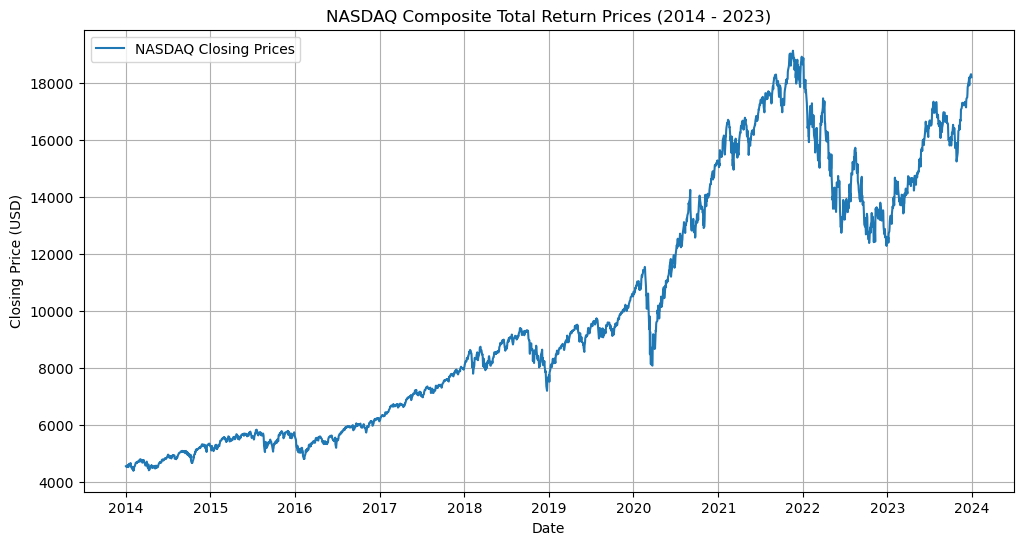

In [4]:
# Plotting the Closing Prices
plt.figure(figsize=(12, 6))
plt.plot(XCMP_data.index, XCMP_data['Adj Close'], label='NASDAQ Closing Prices')
plt.title('NASDAQ Composite Total Return Prices (2014 - 2023)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Technical Indicators Overview

Below is a list of various technical indicators integrated with moving averages to predict market tre
:

- **SMA (Simple Moving Average)**
  - Calculates the average of a selected range of prices, typically closing prices, over a defined number of periods, smoothing out price data.

- **MA (Moving Average, including Exponentially Weighted)**
  - Averages prices over a period, with variations like the Exponential Moving Average (EMA) that gives more weight to recent prices, making it more responsive to new information.

- **RSI (Relative Strength Index)**
  - A momentum oscillator that measures the speed and change of price movements, with levels identified at 70 (overbought) and 30 (oversold).

- **Stochastic Oscillator (Stochastic K)**
  - Compares a specific closing price of a security to its price range over a certain period, helping identify momentum changes.

- **MACD (Moving Average Convergence Divergence)**
  - A trend-following momentum indicator showing the relationship between two moving averages of a security's prices.

- **CCI (Commodity Channel Index)**
  - An oscillator that measures the variation of a security's price from its statistical mean, highlighting periods of overbought or oversold conditions.

- **ATR (Average True Range)**
  - Measures market volatility by decomposing the entire range of an asset price for that period.

- **Acc/Dist (Accumulation/Distribution Line)**
  - Measures the cumulative flow of money into and out of a security, indicating whether the stock is being accumulated or distributed.

- **Bollinger Bands**
  - Uses a moving average with two trading bands above and below it. Unlike a simple moving average, the bands widen during periods ofherawer.
during less volatile periods.

Each indicator can help traders understand different aspects of market behavior and can be used in combination to make more informed trading decisions.


In [5]:
def add_derived_indicators (df, ma_periods, ema_periods, momentum_periods, return_periods):
    """
    Enhance the dataframe with technical indicators.
    
    Parameters:
    df (DataFrame): Original dataframe with stock data.
    ma_periods (list): List of periods for calculating moving averages.
    ema_periods (list): List of periods for calculating exponential moving averages.
    momentum_periods (list): List of periods for calculating momentum.
    return_periods (list): List of periods for calculating returns.
    
    Returns:
    DataFrame: Enhanced dataframe with new technical indicators.
    """
    
    # Moving averages
    for period in ma_periods: 
        
        df[f'MA_{period}'] = df['Adj Close'].rolling(period).mean()

    # Exponential moving averages
    for period in ema_periods:
        df[f'EMA_{period}'] = df['Adj Close'].ewm(span=period, adjust=False).mean()

    # Moving Average Convergence Divergence
    
    #calculating the indicator
    macd_indicator = MACD(df['Adj Close'], window_slow=26, window_fast=12, window_sign=9)

    # Addind data to the DataFrame
    df['MACD'] = macd_indicator.macd()
    df['MACD_signal'] = macd_indicator.macd_signal()
    df['MACD_diff'] = macd_indicator.macd_diff()    

    # Calculate the RSI for the closing prices
    df['RSI'] = rsi(df['Adj Close'], window=14)
    
    # Calculate the Stochastic %K
    # The window parameter defines the lookback period for calculating %K,
    # and smooth_window parameter is used for smoothing the %K line.
    stochastic_oscillator = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Adj Close'], window=14, smooth_window=3)

    # Add the %K line to the DataFrame   
    df['stochastic_k'] = stochastic_oscillator.stoch()
    
    # Commodity Channel Index (CCI)
    df['CCI'] = cci(df['High'], df['Low'], df['Adj Close'], window=20)
    
    # Average True Range (ATR)
    df['ATR'] = average_true_range(df['High'], df['Low'], df['Adj Close'], window=14)
    
    # Calculate the Accumulation/Distribution Index
    adi = AccDistIndexIndicator(high=df['High'], low=df['Low'], close=df['Adj Close'], volume=df['Volume'])
    df['A/D Index'] = adi.acc_dist_index()
    
    # Returns for specified periods
    for period in return_periods:
        df[f'Return_{period}d'] = df['Adj Close'].pct_change(period)
    
    # Momentum for specified periods
    for period in momentum_periods:
        df[f'Momentum_{period}d'] = df['Adj Close'].diff(period)

    # Initialize Bollinger Bands Indicator with window size (usually 20) and standard deviation multiplier (usually 2)
    bb_indicator = BollingerBands(close=df['Adj Close'], window=20, window_dev=2)
    
    # Calculate the Bollinger Bands
    df['Bollinger High'] = bb_indicator.bollinger_hband()  # Upper Band
    df['Bollinger Low'] = bb_indicator.bollinger_lband()   # Lower Band
    df['Bollinger SMA'] = bb_indicator.bollinger_mavg()    # Moving Average (SMA)

    return df




In [6]:
ma_periods = [10, 20, 50]
ema_periods = [10, 20, 50]
momentum_periods = [1, 5, 10]
return_periods = [1, 5, 10]
XCMP_data_derived_indicators = add_derived_indicators(XCMP_data, ma_periods, ema_periods, momentum_periods, return_periods)

In [7]:
print(XCMP_data_derived_indicators.tail())

                Open      High       Low      Volume  Adj Close      MA_10  \
Date                                                                         
2023-12-22  18199.23  18248.97  18103.35   881138226   18183.22  17937.366   
2023-12-26  18226.55  18314.47  18220.95   880275147   18282.20  18015.690   
2023-12-27  18302.18  18331.79  18256.10  1072083217   18313.72  18084.866   
2023-12-28  18366.93  18376.60  18300.38   909092166   18309.97  18129.333   
2023-12-29  18315.05  18329.86  18140.59  1042297151   18208.50  18160.175   

                 MA_20       MA_50        EMA_10        EMA_20  ...  \
Date                                                            ...   
2023-12-22  17613.3760  16855.9422  17931.368493  17662.015872  ...   
2023-12-26  17664.4810  16896.9474  17995.156040  17721.081027  ...   
2023-12-27  17714.6875  16934.6902  18053.076760  17777.522834  ...   
2023-12-28  17766.0655  16973.1870  18099.784622  17828.232088  ...   
2023-12-29  17814.1715  170

## Adding External Indicators to the DataFrame

This function adds external economic indicators to the stock data. The external indicators used in this case are:

- **USDX (U.S. Dollar Index)**: Measures the value of the U.S. dollar relative to a basket of foreign currencies.
- **EFFR (Effective Federal Funds Rate)**: The interest rate at which depository institutions trade federal funds overnight.
- **UNRATE (Unemployment Rate)**: The percentage of the labor force that is unemployed.

The function is generic and can be extended to load and integrate additional external data as needed.


In [8]:
def add_external_indicators (df, file_paths):
    """
    Enhance the dataframe with external indicators.
    
    Parameters:
    df (DataFrame): Original dataframe with stock data.
    
    Returns:
    DataFrame: Enhanced dataframe with new external indicators.
    """

    # Iterate over each file path in the list
    for file_path in file_paths:
        # Load the current file into a DataFrame
        new_df = pd.read_excel(file_path)
        
        # Ensure the 'Date' column is set as index if it hasn't been already
        if 'Date' not in new_df.columns:
            print(f"No 'Date' column in {file_path}. Skipping this file.")
            continue
        
        new_df.set_index('Date', inplace=True)
        
        # Merge the new DataFrame into the base DataFrame
        df = df.join(new_df, how='left', rsuffix='_new')
            
    return df

In [9]:
XCMP_data_all_indicators = add_external_indicators(XCMP_data_derived_indicators,['Data/EFFR.xlsx','Data/DXY.xlsx','Data/UNRATE.xlsx'])

## Defining the Target Column for Stock Price Prediction

In this section, we define the target column 'Target' for our stock price prediction model. This column is created by assessing the change in the adjusted close price of the stock from the previous day. The target is set to `1` if there is an increase (positive change) and `0` if there is a decrease or no change.

We then count the occurrences of each target value to understand the distribution of our dataset and plot these counts in a bar chart to visually inspect the balance between rising and falling stock prices.stable.


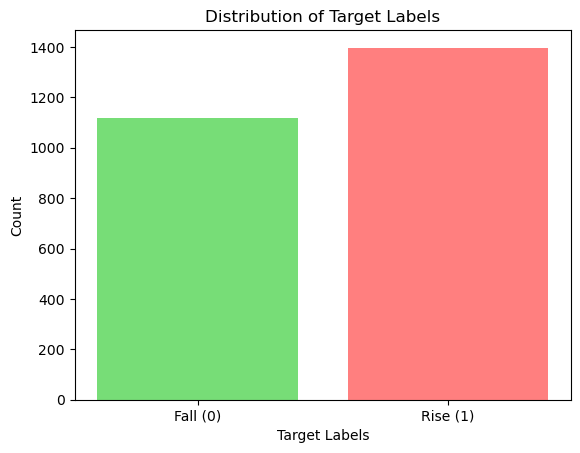

In [10]:
# Directly create the Target column based on percentage price changes from the previous day
XCMP_data_all_indicators['Target'] = XCMP_data_all_indicators['Adj Close'].pct_change().apply(lambda x: 1 if x > 0 else 0)

# Count the occurrences of each Target value
target_counts = XCMP_data_all_indicators['Target'].value_counts()

# Plotting the results in a bar chart
plt.bar(target_counts.index, target_counts.values, color=['#FF7F7F', '#77DD77'])
plt.xlabel('Target Labels')
plt.ylabel('Count')
plt.title('Distribution of Target Labels')
plt.xticks(ticks=target_counts.index, labels=['Rise (1)', 'Fall (0)'])
plt.show()


## Removing Missing Values and Dataset Information

The next code removes rows with missing values from the `XCMP_data_all_indicators` DataFrame using `dropna(inplace=True)`, and then prints the first 5 rows to verify the removal. It also provides dataset information (data types and non-null values) via `info()`. A separator is added for clearer output presentation.



In [11]:
# Display the first few rows of the data to get an overview
print("First 5 rows of the dataset:")
print(XCMP_data_all_indicators.head())
print("\n" + "="*50 + "\n")  # Separator

# Get information about the dataset, including data types and non-null values
print("Dataset Information:")
print(XCMP_data_all_indicators.info())
print("\n" + "="*50 + "\n")  # Separator

# Check for any missing values in the dataset
print("Missing values in each column:")
print(XCMP_data_all_indicators.isnull().sum())
print("\n" + "="*50 + "\n")  # Separator

# Display the column names to see what parameters are available
print("Column names in the dataset:")
print(XCMP_data_all_indicators.columns)
print("\n" + "="*50 + "\n")  # Separator

# Get basic statistical details of the dataset
print("Statistical summary of numerical columns:")
print(XCMP_data_all_indicators.describe())


First 5 rows of the dataset:
               Open     High      Low     Volume  Adj Close  MA_10  MA_20  \
Date                                                                        
2014-01-02  4563.58  4564.60  4532.60  446910020    4544.97    NaN    NaN   
2014-01-03  4551.02  4555.85  4525.14  396555891    4532.75    NaN    NaN   
2014-01-06  4538.40  4541.41  4501.88  537649195    4512.78    NaN    NaN   
2014-01-07  4529.15  4561.64  4526.86  525550217    4556.15    NaN    NaN   
2014-01-08  4557.42  4576.59  4547.24  560593013    4569.85    NaN    NaN   

            MA_50       EMA_10       EMA_20  ...  Momentum_1d  Momentum_5d  \
Date                                         ...                             
2014-01-02    NaN  4544.970000  4544.970000  ...          NaN          NaN   
2014-01-03    NaN  4542.748182  4543.806190  ...       -12.22          NaN   
2014-01-06    NaN  4537.299421  4540.851315  ...       -19.97          NaN   
2014-01-07    NaN  4540.726799  4542.3083

In [12]:
XCMP_data_all_indicators.dropna(inplace=True)
print(XCMP_data_all_indicators.head())

               Open     High      Low     Volume  Adj Close     MA_10  \
Date                                                                    
2014-03-14  4673.88  4697.95  4664.52  530243493    4668.32  4743.580   
2014-03-17  4700.20  4729.96  4698.87  468683676    4706.50  4744.067   
2014-03-18  4713.46  4766.72  4711.14  468700809    4765.24  4742.218   
2014-03-19  4763.22  4766.35  4710.52  492518340    4736.99  4736.847   
2014-03-20  4726.44  4761.21  4714.81  446756648    4749.86  4733.374   

                MA_20      MA_50       EMA_10       EMA_20  ...  Momentum_1d  \
Date                                                        ...                
2014-03-14  4722.7030  4615.9400  4722.832571  4703.404725  ...       -16.48   
2014-03-17  4724.9380  4619.1706  4719.863013  4703.699513  ...        38.18   
2014-03-18  4728.4325  4623.8204  4728.113374  4709.560512  ...        58.74   
2014-03-19  4732.4250  4628.3046  4729.727306  4712.172844  ...       -28.25   
2014-03-

## Standardize Numeric Columns in DataFrame

This code standardizes all numeric columns, excluding the 'Date' and 'Target' columns, within a DataFrame. After standardizing, it applies a custom weight to the `Momentum_1d` column to increase its influence during model training.


In [13]:
# Initializing the StandardScaler
scaler = StandardScaler()

# Selecting all columns except 'Date' for standardization
columns_to_scale = XCMP_data_all_indicators.columns.difference(['Date', 'Target'])

# Standardizing the selected columns
XCMP_data_all_indicators[columns_to_scale] = scaler.fit_transform(XCMP_data_all_indicators[columns_to_scale])

# Get information about the dataset
print("Dataset Information:")
print(XCMP_data_all_indicators.describe())
print("\n" + "="*50 + "\n")


Dataset Information:
               Open         High          Low        Volume     Adj Close  \
count  2.467000e+03  2467.000000  2467.000000  2.467000e+03  2.467000e+03   
mean  -2.764982e-16     0.000000     0.000000  1.382491e-16 -2.764982e-16   
std    1.000203e+00     1.000203     1.000203  1.000203e+00  1.000203e+00   
min   -1.306444e+00    -1.302511    -1.318811 -1.526793e+00 -1.310753e+00   
25%   -9.690978e-01    -0.972256    -0.968342 -7.055635e-01 -9.693563e-01   
50%   -2.679260e-01    -0.263705    -0.262104 -3.780797e-01 -2.635194e-01   
75%    9.157659e-01     0.918197     0.909533  5.881416e-01  9.074260e-01   
max    2.069592e+00     2.061682     2.077976  1.033283e+01  2.052111e+00   

              MA_10        MA_20         MA_50        EMA_10        EMA_20  \
count  2.467000e+03  2467.000000  2.467000e+03  2.467000e+03  2.467000e+03   
mean  -9.216606e-17     0.000000  9.216606e-17  1.843321e-16  2.764982e-16   
std    1.000203e+00     1.000203  1.000203e+00  1.0

In [14]:
# Get information about the dataset, including data types and non-null values
print("Dataset Information:")
print(XCMP_data_all_indicators.describe())
print("\n" + "="*50 + "\n")  # Separator

Dataset Information:
               Open         High          Low        Volume     Adj Close  \
count  2.467000e+03  2467.000000  2467.000000  2.467000e+03  2.467000e+03   
mean  -2.764982e-16     0.000000     0.000000  1.382491e-16 -2.764982e-16   
std    1.000203e+00     1.000203     1.000203  1.000203e+00  1.000203e+00   
min   -1.306444e+00    -1.302511    -1.318811 -1.526793e+00 -1.310753e+00   
25%   -9.690978e-01    -0.972256    -0.968342 -7.055635e-01 -9.693563e-01   
50%   -2.679260e-01    -0.263705    -0.262104 -3.780797e-01 -2.635194e-01   
75%    9.157659e-01     0.918197     0.909533  5.881416e-01  9.074260e-01   
max    2.069592e+00     2.061682     2.077976  1.033283e+01  2.052111e+00   

              MA_10        MA_20         MA_50        EMA_10        EMA_20  \
count  2.467000e+03  2467.000000  2.467000e+03  2.467000e+03  2.467000e+03   
mean  -9.216606e-17     0.000000  9.216606e-17  1.843321e-16  2.764982e-16   
std    1.000203e+00     1.000203  1.000203e+00  1.0

## Correlation Matrix and Heatmap Visualization

This code calculates the correlation matrix for all numerical columns in the `XCMP_data_all_indicators` DataFrame and visualizes it using a heatmap. The heatmap provides a color-coded representation of the correlations between the variables, with annotations showing the exact correlation values. The size and color map of the heatmap are customized for clarity.


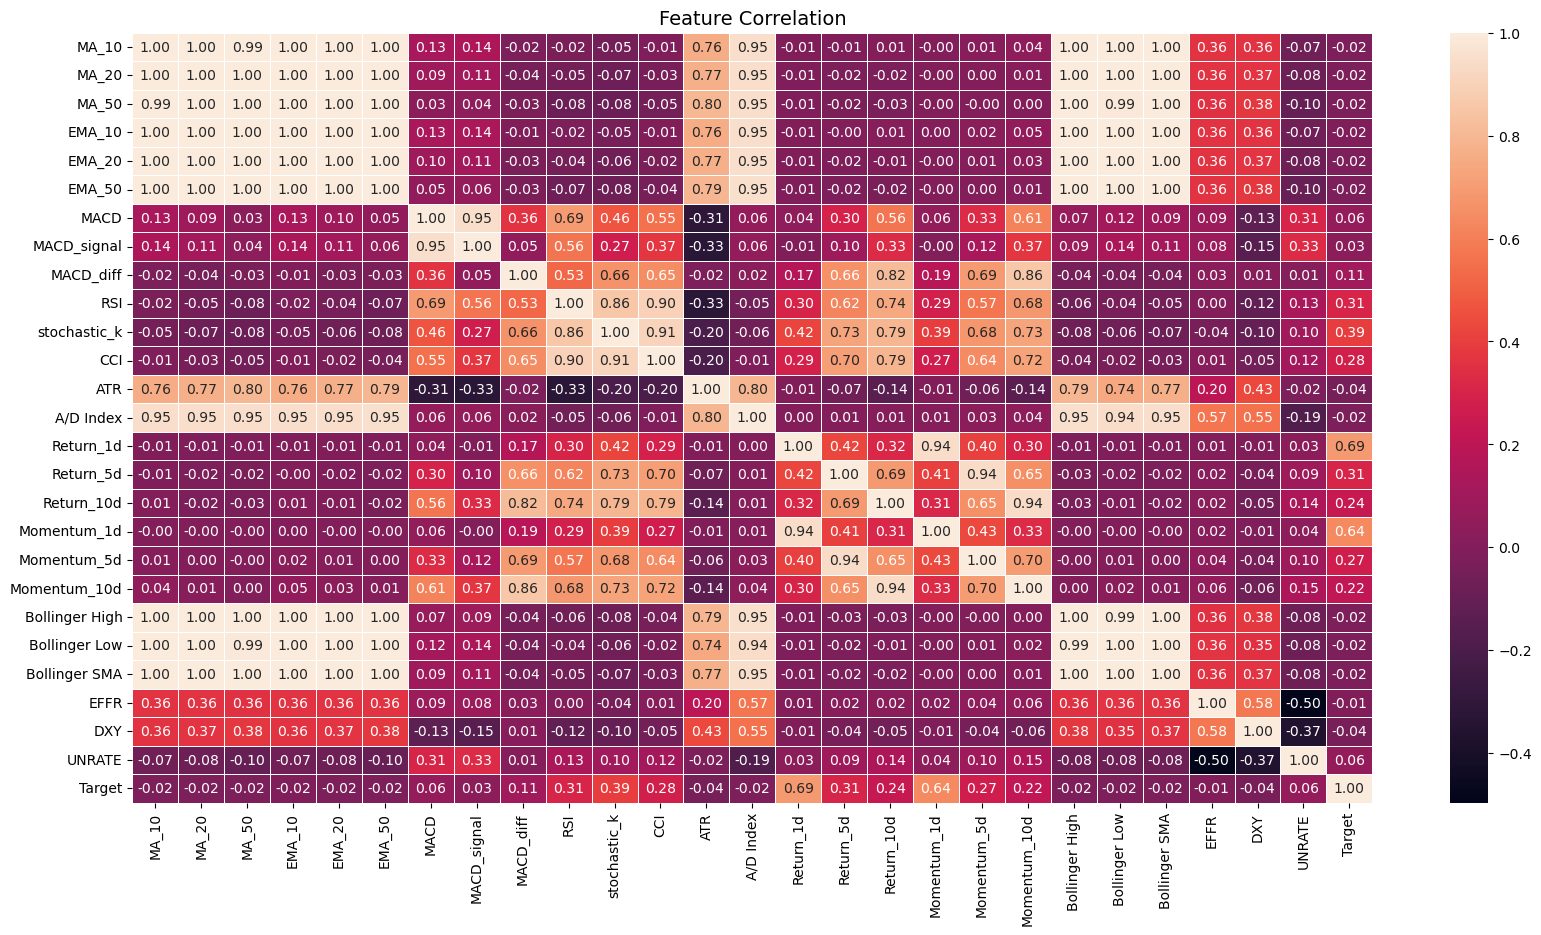

In [15]:

corrmat = XCMP_data_all_indicators.drop(['Adj Close', 'High','Low','Volume','Open'], axis=1).corr()

# Visualize feature correlation with 'Target'
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, ax=ax)
ax.set_title('Feature Correlation', fontsize=14, color='black')
plt.show()

In [16]:

# Set a threshold for low correlation
threshold = 0.1

# Find the absolute correlations with the target column
target_correlations = corrmat['Target'].abs()

# Select features that have an absolute correlation greater than or equal to the threshold
selected_features = target_correlations[target_correlations >= threshold].index

# Create a new DataFrame with only the selected features
XCMP_data_filtered = XCMP_data_all_indicators[selected_features]

# Display the filtered DataFrame
print(f"Selected features based on correlation with the target:\n{selected_features}")
print(XCMP_data_filtered.head())


Selected features based on correlation with the target:
Index(['MACD_diff', 'RSI', 'stochastic_k', 'CCI', 'Return_1d', 'Return_5d',
       'Return_10d', 'Momentum_1d', 'Momentum_5d', 'Momentum_10d', 'Target'],
      dtype='object')
            MACD_diff       RSI  stochastic_k       CCI  Return_1d  Return_5d  \
Date                                                                            
2014-03-14  -0.269272 -0.686878     -1.874561 -1.138339  -0.312267  -0.870445   
2014-03-17  -0.276800 -0.254608     -1.037602 -0.562582   0.566296  -0.565175   
2014-03-18  -0.199099  0.304926      0.250061  0.103408   0.889446   0.114599   
2014-03-19  -0.184706 -0.032583     -0.369218 -0.154060  -0.493337  -0.243401   
2014-03-20  -0.156894  0.089087     -0.087090 -0.118960   0.156049   0.393272   

            Return_10d  Momentum_1d  Momentum_5d  Momentum_10d  Target  
Date                                                                    
2014-03-14   -0.535278    -0.141996    -0.387586     -

# Transforming Data for LSTM Processing

This function, `lstm_data_transform`, is designed to prepare time series data for training LSTM models by applying the sliding window technique. The function restructures data into a 3D array format necessary for LSTM model inputs, where the target values are aligned according to the input sequence.

## Key Components of the Function:

- **Sliding Window Technique**: The function employs a sliding window approach to segment the input data into sequences used for LSTM input.
- **Data Structuring**: Converts 2D data into a 3D array, adjusting the shape to [samples, time steps, features] which is essential for time series modeling in neural networks.
- **Target Alignment**: Adjusts the target data array to ensure each target corresponds accurately to the end of each sequence in the input data.

## Function Flexibility:

The function allows for flexibility in setting the number of time steps per sample, which can be adjusted based on the specific requirements of the model or the nature of the data. This flexibility ensures the function can be adapted to different types of time series forecasting tasks.
prediction accuracy.
ning.
.


In [17]:
def lstm_data_transform(x_data, y_data, num_steps):
    """
    Prepares and transforms time series data for LSTM model training by creating sequences of data with corresponding labels.

    Args:
        x_data (array): Input feature data in 2D format.
        y_data (array): Target data in 1D format.
        num_steps (int): Number of time steps to include in each sequence.

    Returns:
        tuple: A tuple containing the transformed x_data in 3D format and the aligned y_data.
    """
    y_data = np.asarray(y_data).astype('float32')
    
    # Define the shape for x_array: the number of sequences, the number of steps, and features per step
    x_shape = (x_data.shape[0] - num_steps, num_steps, x_data.shape[1])
    
    # Initialize an empty x_array with the shape calculated
    x_array = np.zeros(x_shape)

    # Ensure the labels align with the sequences
    y_array = y_data[num_steps:]  
    
    # Loop over num_steps and fill the x_array with the correct sequence data
    for i in range(num_steps):
        # For each step, fill the corresponding values into x_array for all sequences
        x_array[:, i, :] = x_data[i:x_shape[0] + i]
    
    return x_array, y_array


In [18]:
# Extract the 'Target' column (which contains 0 for fall and 1 for rise) as y (labels)
y = XCMP_data_filtered['Target']

# Drop the 'Target' column from the features
X = XCMP_data_filtered.drop(columns=['Target'])

feature_names =  XCMP_data_filtered.columns.tolist()
            
# The data is sorted by date, calculate the split indices
train_size = int(len(X) * 0.7)  # 70% for training
val_size = int(len(X) * 0.15)   # 15% for validation (next 15%)
test_size = len(X) - train_size - val_size  # Remaining 15% for testing

# Split data into training, validation, and test sets
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Number of time steps to use for each input sequence
time_steps = 10

# Transform both training, validation, and testing data
X_train_transformed, y_train_transformed = lstm_data_transform(X_train, y_train, time_steps)
X_val_transformed, y_val_transformed = lstm_data_transform(X_val, y_val, time_steps)
X_test_transformed, y_test_transformed = lstm_data_transform(X_test, y_test, time_steps)

num_features = X_train_transformed.shape[2]


### Building the LSTM Model

This function, `build_lstm_model`, constructs and compiles an LSTM (Long Short-Term Memory) model for time series prediction. The function is tailored to work with preprocessed input data that has already been split into training sets and where the target values are one-hot encoded.

#### Key Components of the Function:
- **Model Architecture:** The architecture is dynamically constructed based on the specified parameters such as the number of layers and neurons per layer. This modular design supports easy modifications to adapt the model's depth and width, accommodating various complexities and capacities.
- **Dropout:** To help prevent overfitting, dropout layers are included in the model. These layers randomly omit a portion of neuron activations during the training process.
- **Compilation:** The model is compiled using a chosen optimizer and a specific loss function, `categorical_crossentropy`, which is suitable for multi-class classification problems.

#### Function Flexibility:
The function's structure is designed to facilitate fine-tuning and is highly configurable. Parameters such as the number of LSTM layers, the number of neurons in each layer, and the dropout rate are adjustable, allowing for extensive experimentation to optimize model performance. This flexibility ensures that the model configuration aligns well with the categorical nature of the target data.
et data.


In [19]:
def build_lstm_model(num_features, time_steps, n_neurons, dropout_rate=0.2, l1_value=0.01, optimizer='adam', metrics=['accuracy']):
    """
    Constructs and compiles an LSTM model for time series prediction based on architecture parameters and training configuration.

    Args:
        num_features (int): Number of features in each input sample.
        time_steps (int): Number of past records to consider for predicting a future value.
        n_layers (int): Number of LSTM layers.
        n_neurons (list): List containing the number of neurons for each LSTM layer.
        dropout_rate (float): Dropout rate to prevent overfitting.
        optimizer (str): Optimizer for compiling the model.
        metrics (list): List of metrics to evaluate the model.

    Returns:
        keras.engine.sequential.Sequential: Compiled LSTM model.
    """
    
    model = Sequential()
    model.add(Input(shape=(time_steps, num_features)))  # Input layer

    # Extract the number of layers from the length of the n_neurons list
    n_layers = len(n_neurons)
    
    # Add LSTM layers
    for i in range(n_layers - 1):
        model.add(LSTM(n_neurons[i], return_sequences=True, 
                       kernel_regularizer=l1(l1_value)))  # L1 regularization for LSTM
        model.add(Dropout(dropout_rate))

    # Final LSTM layer with return_sequences=False
    model.add(LSTM(n_neurons[-1], return_sequences=False, 
                   kernel_regularizer=l1(l1_value)))  # L1 regularization for the last LSTM
    model.add(Dropout(dropout_rate))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model



# LSTM Model Training and Evaluation

In this cell, we define and train an LSTM model for time series prediction. The model consists of multiple LSTM layers with dropout regularization to prevent overfitting. The training process includes validation data to monitor model performance during training.

After training, the model is evaluated on the test set to assess its accuracy.


In [20]:
# # Parameters
# n_layers = 7  # Number of LSTM Layers
# n_neurons = [200, 100, 100, 100, 100, 100, 100]  # Number of neurons in each layer
# dropout_rate = 0.1  # Dropout rate to prevent overfitting
# optimizer = 'adam'  # Optimizer for the model
# metrics = ['accuracy']  # Metrics to evaluate the model
# epochs = 50  # Number of epochs to train the model
# batch_size = 32  # Batch size for training

# # Define the number of features and time steps (from your data processing)
# num_features = X_train_transformed.shape[2]  # Assuming 3D input for LSTM (samples, timesteps, features)
# time_steps = X_train_transformed.shape[1]  # Define number of timesteps from your training data

# # Build the LSTM model
# model_lstm = build_lstm_model(
#     meta={'n_features_in_': num_features},  # Passing the number of features
#     n_layers=n_layers,
#     n_neurons=n_neurons,
#     dropout_rate=dropout_rate,
#     optimizer=optimizer
# )

# # Compile the model
# model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

# # Train the model with the validation data
# history = model_lstm.fit(
#     X_train_transformed,
#     y_train_transformed,
#     validation_data=(X_val_transformed, y_val_transformed),
#     epochs=epochs,
#     batch_size=batch_size,
#     verbose=1
# )

# # Evaluate the model on the test set
# test_loss, test_accuracy = model_lstm.evaluate(X_test_transformed, y_test_transformed, verbose=1)
# print(f"Test Accuracy: {test_accuracy}")


In [21]:
def tune_lstm_hyperparameters(X_train, y_train, X_val, y_val, param_grid):
    """
    Tunes LSTM model by trying different combinations of hyperparameters.

    Args:
        X_train (np.array): Training data features.
        y_train (np.array): Training data labels.
        X_val (np.array): Validation data features.
        y_val (np.array): Validation data labels.
        X_test (np.array): Test data features.
        y_test (np.array): Test data labels.
        param_grid (dict): Dictionary with lists of parameters to try.

    Returns:
    dict: The best parameters and the best accuracy achieved.
    """
    best_accuracy = 0
    best_params = {}
    
    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    # Iterate over all parameter combinations
    for params in param_combinations:
        # Build and train the LSTM model
        model = build_lstm_model(
            num_features=params['num_features'],
            time_steps=params['time_steps'],
            n_neurons=params['n_neurons'],
            dropout_rate=params['dropout_rate'],
            l1_value=params['l1_value'],
            optimizer=params['optimizer'],
            metrics=['accuracy']
        )
        
        model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        # Evaluate the model on the validation set
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        
        # Update the best parameters if the current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            
    return {"best_params": best_params, "best_accuracy": best_accuracy}




In [22]:
param_grid = {
    'num_features': [num_features], 
    'time_steps': [10],          
    'n_neurons': [[200, 100, 100, 100, 100, 100],[200, 100, 100, 100, 100, 100, 100],[200, 100, 100, 100, 100, 100, 100,100],[100,50,50,50,50,50],[100,50,50,50,50,50,50],[100,50,50,50,50,50,50,50],[100,50,50,50,50,50,50,50,50]], # Different neuron configurations
    'dropout_rate':[0.2], #[0.1, 0.2],     # Different dropout rates
    'l1_value': [0.0], #[0.0, 0.001], # Different regularization values
    'optimizer': ['adam'],    # Different optimizers
    'epochs': [50],                  # Different number of epochs
    'batch_size': [64] 
    # Different batch sizes
}

best_params = tune_lstm_hyperparameters(X_train_transformed, y_train_transformed, X_val_transformed, y_val_transformed, param_grid)
print("Best parameters:", best_params['best_params'])
print("Best accuracy:", best_params['best_accuracy'])


Best parameters: {'num_features': 10, 'time_steps': 10, 'n_neurons': [200, 100, 100, 100, 100, 100], 'dropout_rate': 0.2, 'l1_value': 0.0, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 64}
Best accuracy: 0.5527777671813965


In [28]:

# Extract the best parameters from the tuning result
best_n_neurons = best_params['best_params']['n_neurons']
best_dropout_rate = best_params['best_params']['dropout_rate']
best_optimizer = best_params['best_params']['optimizer']
best_l1_value = best_params['best_params']['l1_value']
best_epochs = best_params['best_params']['epochs']
best_batch_size = best_params['best_params']['batch_size']

# Now, rebuild and train the model with these best parameters
model_lstm = build_lstm_model(
    num_features=num_features,  
    time_steps=10,              
    n_neurons=best_n_neurons,
    dropout_rate=best_dropout_rate,
    l1_value=best_l1_value,
    optimizer=best_optimizer,
    metrics=['accuracy']
)

# Train the model on the full dataset
history = model_lstm.fit(
    X_train_transformed,        # Full training set
    y_train_transformed,        # Full training labels
    epochs=best_epochs,        
    batch_size=best_batch_size, 
    validation_data=(X_val_transformed, y_val_transformed),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test_transformed, y_test_transformed, verbose=1)
print(f"Final Test Accuracy: {test_accuracy}")

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5416 - loss: 0.6890 - val_accuracy: 0.5250 - val_loss: 0.6974
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5787 - loss: 0.6812 - val_accuracy: 0.5250 - val_loss: 0.6957
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5682 - loss: 0.6837 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5757 - loss: 0.6839 - val_accuracy: 0.5250 - val_loss: 0.6942
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5628 - loss: 0.6848 - val_accuracy: 0.5250 - val_loss: 0.6966
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5752 - loss: 0.6818 - val_accuracy: 0.5167 - val_loss: 0.6936
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5637 - loss: 0.6843 - val_accuracy: 0.5250 - val_loss: 0.6991
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5712 - loss: 0.6829 - val_accuracy: 0.5250 - v

## Confusion Matrix for Model Predictions

This cell generates and displays a confusion matrix to evaluate the model's predictions on the test set. The predicted classes are compared against the true labels, with each class representing a stock movement: `0` for a decrease in stock value (fall) and `1` for an increase in stock value (rise). The confusion matrix visualizes the number of correct and incorrect classifications for each of these classes.
.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


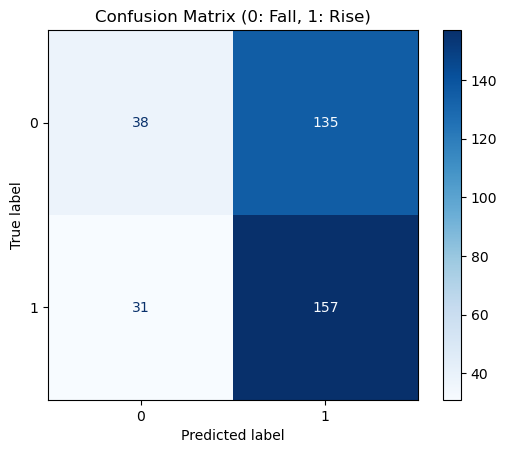

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred_lstm = model_lstm.predict(X_test_transformed)
y_pred_classes = (y_pred_lstm > 0.5).astype(int)  # Convert probabilities to class predictions (threshold 0.5)

# Get true labels 
y_true = y_test_transformed  

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (0: Fall, 1: Rise)")
plt.show()


In [31]:
max_value = np.max(y_pred_lstm)
print(f"The maximum value of y_pred_lstm is: {max_value}")

The maximum value of y_pred_lstm is: 0.8302022814750671


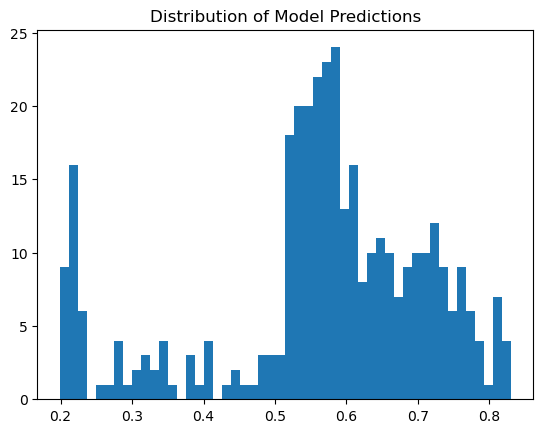

In [32]:
plt.hist(y_pred_lstm, bins=50)
plt.title("Distribution of Model Predictions")
plt.show()


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision
precision = precision_score(y_true, y_pred_classes)
print(f"Precision: {precision:.2f}")

# Calculate Recall
recall = recall_score(y_true, y_pred_classes)
print(f"Recall: {recall:.2f}")

# Calculate F1 Score
f1 = f1_score(y_true, y_pred_classes)
print(f"F1 Score: {f1:.2f}")

Precision: 0.54
Recall: 0.84
F1 Score: 0.65
